In [3]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

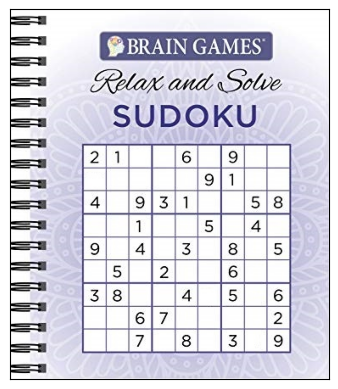

In [5]:
FILE_PATH = '../img/1.jpg'
image = cv2.imread(FILE_PATH)
image_blank = np.zeros_like(image)
plt.imshow(bgr2rgb(image))
plt.xticks([]), plt.yticks([])
plt.show()

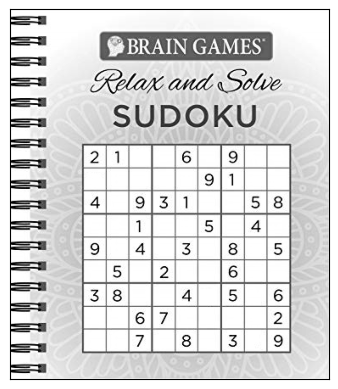

In [6]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

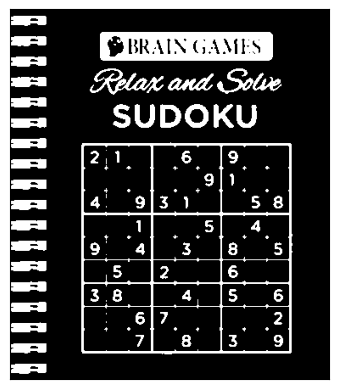

In [7]:
blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
_, thresh_image = cv2.threshold(blur_gray_image, 180, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

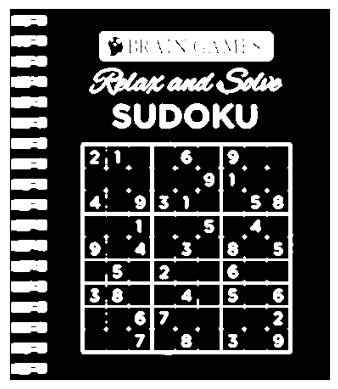

In [8]:
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)
dilated_image = cv2.dilate(thresh_image, kernel, iterations=1)

plt.imshow(dilated_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
def is_valid_sudoku_contour(contour):
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) != 4:
        return False
    
    pts = approx.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    
    side_lengths = [
        distance(rect[0], rect[1]),
        distance(rect[1], rect[2]),
        distance(rect[2], rect[3]),
        distance(rect[3], rect[0])
    ]
    
    avg_side_length = np.mean(side_lengths)
    if not all(abs(side - avg_side_length) / avg_side_length < 0.1 for side in side_lengths):
        return False
    
    def angle(p1, p2, p3):
        a = np.array(p1)
        b = np.array(p2)
        c = np.array(p3)
        ab = b - a
        bc = b - c
        cosine_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        return np.degrees(angle)
    
    angles = [
        angle(rect[0], rect[1], rect[2]),
        angle(rect[1], rect[2], rect[3]),
        angle(rect[2], rect[3], rect[0]),
        angle(rect[3], rect[0], rect[1])
    ]
    
    if not all(80 <= angle <= 100 for angle in angles):
        return False
    
    return True

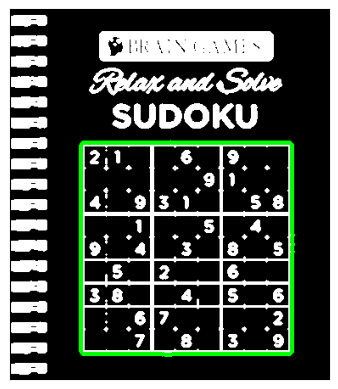

In [10]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)
if not is_valid_sudoku_contour(largest_contour):
    print('No valid sudoku contour found')

contour_image = cv2.cvtColor(dilated_image.copy(), cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)

plt.imshow(bgr2rgb(contour_image))
plt.xticks([]), plt.yticks([])
plt.show()


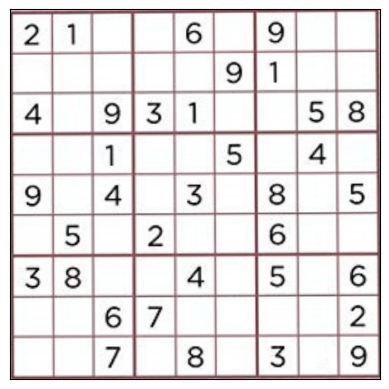

In [11]:
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

pts = approx.reshape(4, 2)

rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

width = 450
height = 450
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
wraped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(wraped_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

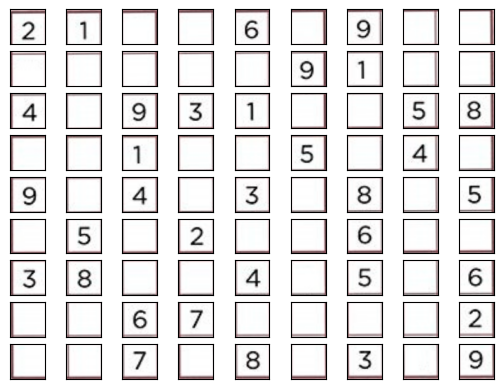

In [12]:
def splitBoxes(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(wraped_image)

for i in range(len(boxes)):
    plt.subplot(9, 9, i+1)
    plt.imshow(boxes[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

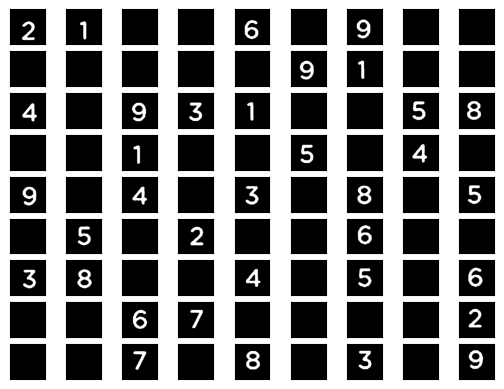

In [13]:
MIN_SIZE = 450
MAX_SIZE = 22500
EDGE_THRESHOLD = 3
w, h = 150, 150

processed_boxes = []

for i in range(len(boxes)):
    target_image = boxes[i]

    gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    gray_target = cv2.resize(gray_target, (w, h))

    _, binary_image = cv2.threshold(gray_target, 180, 255, cv2.THRESH_BINARY_INV)

    num_labels, labels_im = cv2.connectedComponents(binary_image)

    best_component = None
    best_size = 0
    height, width = gray_target.shape
    center_y, center_x = height // 2, width // 2

    for label in range(1, num_labels):
        component_mask = (labels_im == label).astype(np.uint8)
        size = np.sum(component_mask)

        y_indices, x_indices = np.where(component_mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue

        min_y, max_y = np.min(y_indices), np.max(y_indices)
        min_x, max_x = np.min(x_indices), np.max(x_indices)

        if (MIN_SIZE <= size <= MAX_SIZE and
            min_y > EDGE_THRESHOLD and max_y < height - EDGE_THRESHOLD and
            min_x > EDGE_THRESHOLD and max_x < width - EDGE_THRESHOLD):

            if size > best_size:
                best_size = size
                best_component = component_mask

    if best_component is not None:
        mask = best_component.astype(np.uint8) * 255

        output_image = np.zeros_like(gray_target)
        output_image[mask > 0] = 255

        processed_boxes.append(output_image)
    else:
        processed_boxes.append(np.zeros_like(gray_target))

for i in range(len(processed_boxes)):
    plt.subplot(9, 9, i+1)
    plt.imshow(processed_boxes[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [14]:
interpreter = tf.lite.Interpreter(model_path='../digit_recognition_model/num_classifier_150.tflite')
interpreter.allocate_tensors()

(150, 150, 1)


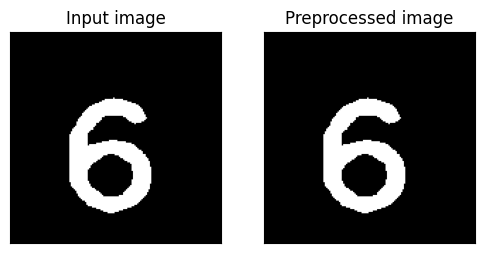

Predicted for sample: [6]


In [15]:
def image_preprocessing_input(image):
    image = cv2.resize(image, (w, h))
    image = cv2.equalizeHist(image)
    _, binary_image = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.reshape(w, h, 1)
    binary_image = binary_image / 255.0
    return binary_image

test_image = processed_boxes[4]
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.title('Input image')
plt.imshow(test_image, cmap='gray')
plt.xticks([]), plt.yticks([])

test_image_preprocessed = image_preprocessing_input(test_image)
print(test_image_preprocessed.shape)
plt.subplot(1, 2, 2)
plt.title('Preprocessed image')
plt.imshow(test_image_preprocessed.reshape(w, h), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

test_image_preprocessed = np.expand_dims(test_image_preprocessed, axis=0)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], test_image_preprocessed.astype(np.float32))

interpreter.invoke()

y_pred = interpreter.get_tensor(output_details[0]['index'])
y_pred_labels = np.argmax(y_pred, axis=1)

print(f'Predicted for sample: {y_pred_labels}')

In [16]:
sudoku_matrix = np.zeros((9, 9), dtype=int)

for i in range(9):
    for j in range(9):
        index = i * 9 + j
        if index < len(processed_boxes):
            if np.sum(processed_boxes[index]) > 0:
                test_image = processed_boxes[index]
                test_image_preprocessed = image_preprocessing_input(test_image)
                test_image_preprocessed = np.expand_dims(test_image_preprocessed, axis=0)

                interpreter.set_tensor(input_details[0]['index'], test_image_preprocessed.astype(np.float32))

                interpreter.invoke()

                y_pred = interpreter.get_tensor(output_details[0]['index'])
                y_pred_labels = np.argmax(y_pred, axis=1)
                sudoku_matrix[i][j] = y_pred_labels[0]
            else:
                sudoku_matrix[i][j] = 0

print("Sudoku Matrix:")
print(sudoku_matrix)

Sudoku Matrix:
[[2 1 0 0 6 0 9 0 0]
 [0 0 0 0 0 9 1 0 0]
 [4 0 9 3 1 0 0 5 8]
 [0 0 1 0 0 5 0 4 0]
 [9 0 4 0 3 0 8 0 5]
 [0 5 0 2 0 0 6 0 0]
 [3 8 0 0 4 0 5 0 6]
 [0 0 6 7 0 0 0 0 2]
 [0 0 7 0 8 0 3 0 9]]


In [17]:
def is_valid_move(matrix, row, col, num):
    if num in matrix[row]:
        return False
    if num in matrix[:, col]:
        return False
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in matrix[start_row:start_row+3, start_col:start_col+3]:
        return False
    return True

def solve_sudoku(matrix):
    for row in range(9):
        for col in range(9):
            if matrix[row][col] == 0:
                for num in range(1, 10):
                    if is_valid_move(matrix, row, col, num):
                        matrix[row][col] = num
                        if solve_sudoku(matrix):
                            return True
                        matrix[row][col] = 0
                return False
    return True

original_matrix = sudoku_matrix.copy()

if solve_sudoku(sudoku_matrix):
    print("Solved")
else:
    print("No solution exists") 

print("Answer Matrix:")
print(sudoku_matrix)

Solved
Answer Matrix:
[[2 1 5 4 6 8 9 3 7]
 [7 3 8 5 2 9 1 6 4]
 [4 6 9 3 1 7 2 5 8]
 [6 2 1 8 9 5 7 4 3]
 [9 7 4 1 3 6 8 2 5]
 [8 5 3 2 7 4 6 9 1]
 [3 8 2 9 4 1 5 7 6]
 [1 9 6 7 5 3 4 8 2]
 [5 4 7 6 8 2 3 1 9]]


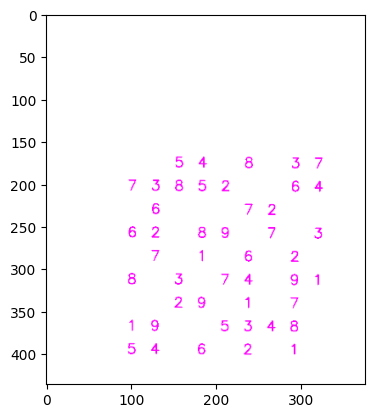

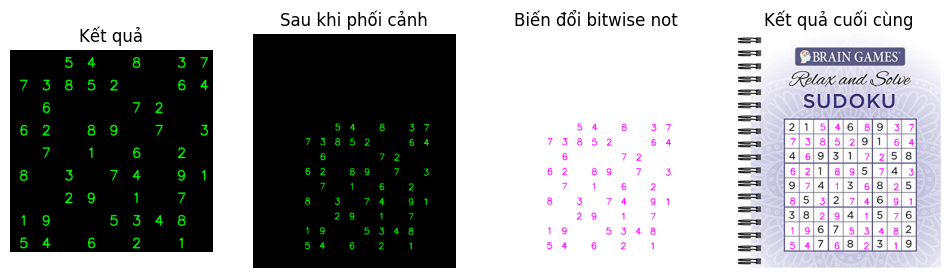

In [25]:
def draw_solution_on_original(original_img, biggest_contour, original_numbers, solved_numbers):
    original_img = original_img.copy()
    blank_image = np.zeros_like(original_img)
    approx = cv2.approxPolyDP(biggest_contour, 0.02 * cv2.arcLength(biggest_contour, True), True)
    pts = approx.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    width, height = 450, 450
    dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(blank_image, M, (width, height))
    
    cell_width = warp.shape[1] // 9
    cell_height = warp.shape[0] // 9
    for i in range(9):
        for j in range(9):
            if original_numbers[i][j] != 0:
                continue
            x = j * cell_width
            y = i * cell_height
            cv2.putText(warp, str(solved_numbers[i][j]), (x + 20, y + 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    
    inv_M = cv2.getPerspectiveTransform(dst, rect)
    inv_warp = cv2.warpPerspective(warp, inv_M, (original_img.shape[1], original_img.shape[0]))
    inv_mask = cv2.bitwise_not(inv_warp)
    # plt.imshow(inv_warp, cmap='gray')
    plt.imshow(inv_mask, cmap='gray')
    result = cv2.bitwise_and(original_img, inv_mask)
    #result = cv2.addWeighted(inv_warp, 1, original_img, 0.5, 1) 
    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    ax[0].imshow(bgr2rgb(warp))
    ax[0].set_title('Kết quả')
    ax[0].axis('off')
    ax[1].imshow(inv_warp, cmap='gray')
    ax[1].set_title('Sau khi phối cảnh')
    ax[1].axis('off')
    ax[2].imshow(inv_mask, cmap='gray')
    ax[2].set_title('Biến đổi bitwise not')
    ax[2].axis('off')
    ax[3].imshow(bgr2rgb(result))
    ax[3].set_title('Kết quả cuối cùng')
    ax[3].axis('off')
    plt.show()
    return result

solved_sudoku = sudoku_matrix - original_matrix
result = draw_solution_on_original(image, largest_contour, original_matrix, solved_sudoku)
# plt.imshow(bgr2rgb(result))

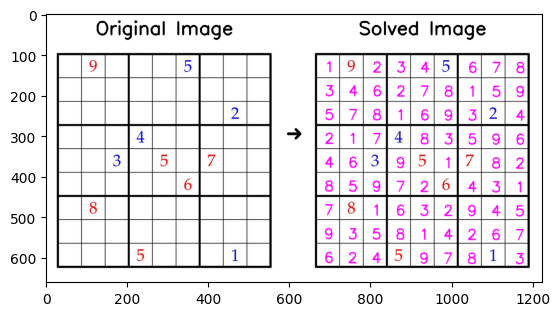

In [106]:
def merge_images(original_img, result_image):
    height, width = original_img.shape[0], original_img.shape[1]
    result_image = cv2.resize(result_image, (width, height))

    arrow_width = 50
    label_height = 70
    canvas_width = width * 2 + arrow_width
    canvas_height = height + label_height
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    background_color = original_img[0, 0].tolist()
    canvas[:label_height, :] = background_color
    canvas[:, width:width + arrow_width]  = background_color

    canvas[label_height:, :width] = original_img

    arrow_start = (width + 10, height // 2)
    arrow_end = (width + arrow_width - 10, height // 2)
    cv2.arrowedLine(canvas, arrow_start, arrow_end, (0, 0, 0), 5, tipLength=0.5)

    canvas[label_height:, width + arrow_width:] = result_image

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 3
    text_color = (0, 0, 0)
    
    original_text = 'Original Image'
    solved_text = 'Solved Image'
    (orig_text_width, orig_text_height), _ = cv2.getTextSize(original_text, font, font_scale, font_thickness)
    (solved_text_width, solved_text_height), _ = cv2.getTextSize(solved_text, font, font_scale, font_thickness)
    
    orig_text_x = (width - orig_text_width) // 2
    solved_text_x = width + arrow_width + (width - solved_text_width) // 2
    
    cv2.putText(canvas, original_text, (orig_text_x, label_height - 20), font, font_scale, text_color, font_thickness)
    cv2.putText(canvas, solved_text, (solved_text_x, label_height - 20), font, font_scale, text_color, font_thickness)

    return canvas

final_image = merge_images(image, result)
plt.imshow(bgr2rgb(final_image))